In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from data_utils import dataset_split

import wandb

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## DATALOADER

In [3]:
# Preprocessing
data_transform = transforms.Compose(
    {
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) # mean, #std
    }
)

fashion_mnist_data = FashionMNIST(os.getcwd() + '\\data',download=True,train=True, transform = data_transform)

In [4]:
data_set = dataset_split(fashion_mnist_data, split = [0.9, 0.1])
train_data = data_set['train']
val_data = data_set['val']

train_batch_size =100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size = train_batch_size, shuffle = True, num_workers = 1
)

val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=val_batch_size, shuffle=True, num_workers=1
)

In [5]:
for sample_batch in train_dataloader:
    #print(sample_batch)
    print(sample_batch[0].shape,sample_batch[1].shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


## MLP (Multi-layer Perceptron) Define

In [6]:
#define Model

class MLP(nn.Module):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        #out = F.softmax(out)
        return out

class MLPWithDropout(MLP):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: float):
        super().__init__(in_dim, h1_dim, h2_dim, out_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        out = self.linear3(x)
        #out = F.softmax(out)
        return out

## Learning Rate Scheduler

In [7]:
# Warmup Schedular
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self,optimizer: optim.Optimizer,warmup_end_steps: int,last_epoch: int = -1,):
        def wramup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps,1))
            else:
                return 1.0
        super().__init__(optimizer, wramup_fn, last_epoch)


## Model, Loss func, Optimizer and Logger Define

In [17]:
# define model
#model = MLP(28*28,128,64,10).to(device)
model = MLPWithDropout(28*28,128,64,10,dropout_prob=0.3).to(device)
model_name = type(model).__name__

# define Loss
loss_function = nn.CrossEntropyLoss()

# define optimizer
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
#optimizer = torch.optim.SGD(model.parameters(),lr = lr)
#optimizer = torch.optim.RAdam(model.parameters(),lr = lr)
optimizer_name = type(optimizer).__name__
max_epoch = 30

# define scheduler
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

# define tensorboard logger
run_name = f"{str(datetime.now()).replace(':','-').split('.')[0]}-{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
log_dir = f"runs/{run_name}"
writer = SummaryWriter(log_dir=log_dir)
log_interval = 100

# define wandb
project_name = "deep_learning_study"
run_tags = [project_name]

wandb.init(
    project = project_name,
    name = run_name,
    tags = run_tags,
    config = {"lr" : lr, "model_name":model_name,"optimizer_name":optimizer_name,"scheduler_name":scheduler_name},
    reinit = True,
)

#set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)


wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Early Stopping callback Object Class Define

In [18]:
# With some modifications, source from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path ='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int) : How long to wait after last time validation loss improved
                             Default: 7
            verbose (bool) : If True, prints a message for each validation loss improvement.
                             Default: False
            delta (float) : Minimum change in the monitored quantity to qualify as an improvement.
                             Default: 0
            path (str) : Path for the checkpoint to be saved to
                         Default: 'checkpoint.ckpt'
            trace_func (function) : trace print function.
                         Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter +=1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >=self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        filename = 'model.ckpt'
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir,f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

In [19]:
# %load_ext tensorboard
# %tensorboard --logdir runs/

# Define EarlyStopping.
early_stopper = EarlyStopping(
    patience= 3, verbose=True, path = os.path.join(log_model_path,'model.ckpt')
)

# Do train with validation
train_step = 0
for epoch in range(1, max_epoch +1):
    # Valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position = 0, leave=True,desc='validation')
        ):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            #Forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            # loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds ==  val_labels.data) / val_outputs.shape[0]

    # Valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)


    #print(f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}")

    # tensorboard log
    writer.add_scalar("Loss/val", val_epoch_loss, train_step)
    writer.add_scalar("Acc/val", val_epoch_acc, train_step)
    writer.add_images("Images/val", val_images.detach().cpu(), train_step)

    # wandb log
    wandb.log({
        "Loss/val": val_epoch_loss,
        "Acc/val": val_epoch_acc,
        "Images/val": wandb.Image(val_images.detach().cpu()),
        "Outputs/val": wandb.Histogram(val_outputs.detach().cpu().numpy()), # .detach()
        "Preds/val": wandb.Histogram(val_preds.detach().cpu().numpy()),
        "Labels/val": wandb.Histogram(val_labels.detach().cpu().numpy()),
    }, step=train_step)

    # Check model early stopping point & save model if model reached the best performance
    early_stopper(val_epoch_loss,model)
    if early_stopper.early_stop:
        break

    # Train step
    current_loss = 0
    current_corrects = 0
    model.train()

    for batch_idx, (images, labels) in enumerate(
        tqdm(train_dataloader,position=0,leave=True,desc='training')
    ):
        images = images.to(device)
        labels = labels.to(device)

        current_loss=0.0
        current_corrects = 0

        # Forward
        # get predictions
        outputs = model(images)
        _, preds =torch.max(outputs, 1)

        # get loss
        loss = loss_function(outputs, labels) # input , target

        # Backpropagation
        # optimizer initialization
        optimizer.zero_grad()

        #Perform backward pass
        loss.backward()

        #Perform Optimization
        optimizer.step()

        #Perform LR scheduler Work
        if scheduler is not None:
            scheduler.step()

        current_loss += loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects / log_interval

            # print(f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}")

            # tensorboard log
            writer.add_scalar("Loss/train", train_loss, train_step)
            writer.add_scalar("Acc/train", train_acc, train_step)
            writer.add_images("Images/train", images.detach().cpu(), train_step)
            writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0], train_step)
            writer.add_graph(model,images)

            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images.detach().cpu()),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.detach().cpu().numpy()),
                "Learning Rate": scheduler.get_last_lr()[0],
            }, step=train_step)

            current_loss = 0
            current_corrects = 0

        train_step +=1
    print(f"epoch: {epoch}, train_loss: {train_loss}, train_acc: {train_acc}")

writer.close()
wandb.finish()

validation: 100%|██████████| 600/600 [00:02<00:00, 257.65it/s]


Validation loss decreased (inf --> 0.231172). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.71it/s]


epoch: 1, train_loss: 0.01563370704650879, train_acc: 0.5


validation: 100%|██████████| 600/600 [00:02<00:00, 269.52it/s]


Validation loss decreased (0.231172 --> 0.133033). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.55it/s]


epoch: 2, train_loss: 0.008168198466300965, train_acc: 0.7199999690055847


validation: 100%|██████████| 600/600 [00:02<00:00, 279.53it/s]


Validation loss decreased (0.133033 --> 0.067381). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.10it/s]


epoch: 3, train_loss: 0.00806488335132599, train_acc: 0.7199999690055847


validation: 100%|██████████| 600/600 [00:02<00:00, 264.29it/s]


Validation loss decreased (0.067381 --> 0.054610). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.63it/s]


epoch: 4, train_loss: 0.006083593368530273, train_acc: 0.8199999928474426


validation: 100%|██████████| 600/600 [00:02<00:00, 265.31it/s]


Validation loss decreased (0.054610 --> 0.049241). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.49it/s]


epoch: 5, train_loss: 0.005254094004631043, train_acc: 0.7899999618530273


validation: 100%|██████████| 600/600 [00:02<00:00, 277.05it/s]


Validation loss decreased (0.049241 --> 0.045662). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.07it/s]


epoch: 6, train_loss: 0.004579788148403168, train_acc: 0.8499999642372131


validation: 100%|██████████| 600/600 [00:02<00:00, 267.36it/s]


Validation loss decreased (0.045662 --> 0.044322). Saving model...


training: 100%|██████████| 540/540 [00:09<00:00, 59.00it/s]


epoch: 7, train_loss: 0.005035894513130188, train_acc: 0.8199999928474426


validation: 100%|██████████| 600/600 [00:02<00:00, 279.87it/s]


Validation loss decreased (0.044322 --> 0.042313). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.28it/s]


epoch: 8, train_loss: 0.0039355731010437016, train_acc: 0.8499999642372131


validation: 100%|██████████| 600/600 [00:02<00:00, 286.26it/s]


Validation loss decreased (0.042313 --> 0.040800). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.71it/s]


epoch: 9, train_loss: 0.004360899329185486, train_acc: 0.8100000023841858


validation: 100%|██████████| 600/600 [00:02<00:00, 283.39it/s]


Validation loss decreased (0.040800 --> 0.039847). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 62.25it/s]


epoch: 10, train_loss: 0.00425279974937439, train_acc: 0.85999995470047


validation: 100%|██████████| 600/600 [00:02<00:00, 279.51it/s]


Validation loss decreased (0.039847 --> 0.039183). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.41it/s]


epoch: 11, train_loss: 0.003956633508205414, train_acc: 0.8799999952316284


validation: 100%|██████████| 600/600 [00:02<00:00, 271.29it/s]


Validation loss decreased (0.039183 --> 0.038383). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.39it/s]


epoch: 12, train_loss: 0.003964448273181915, train_acc: 0.85999995470047


validation: 100%|██████████| 600/600 [00:02<00:00, 291.34it/s]


Validation loss decreased (0.038383 --> 0.037706). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 62.15it/s]


epoch: 13, train_loss: 0.005593142509460449, train_acc: 0.85999995470047


validation: 100%|██████████| 600/600 [00:02<00:00, 285.79it/s]


Validation loss decreased (0.037706 --> 0.037365). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.60it/s]


epoch: 14, train_loss: 0.0036108970642089845, train_acc: 0.8799999952316284


validation: 100%|██████████| 600/600 [00:02<00:00, 281.65it/s]


Validation loss decreased (0.037365 --> 0.036980). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.69it/s]


epoch: 15, train_loss: 0.004787791967391968, train_acc: 0.8999999761581421


validation: 100%|██████████| 600/600 [00:02<00:00, 290.50it/s]


Validation loss decreased (0.036980 --> 0.036136). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.33it/s]


epoch: 16, train_loss: 0.004575803875923157, train_acc: 0.8199999928474426


validation: 100%|██████████| 600/600 [00:02<00:00, 285.39it/s]


Validation loss decreased (0.036136 --> 0.035673). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 62.15it/s]


epoch: 17, train_loss: 0.003982304334640503, train_acc: 0.8399999737739563


validation: 100%|██████████| 600/600 [00:02<00:00, 291.78it/s]


Validation loss decreased (0.035673 --> 0.035586). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 62.32it/s]


epoch: 18, train_loss: 0.0028723815083503725, train_acc: 0.8899999856948853


validation: 100%|██████████| 600/600 [00:02<00:00, 279.89it/s]


Validation loss decreased (0.035586 --> 0.035399). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.36it/s]


epoch: 19, train_loss: 0.002139446586370468, train_acc: 0.949999988079071


validation: 100%|██████████| 600/600 [00:02<00:00, 290.54it/s]


Validation loss decreased (0.035399 --> 0.035294). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.92it/s]


epoch: 20, train_loss: 0.0034619152545928957, train_acc: 0.8499999642372131


validation: 100%|██████████| 600/600 [00:02<00:00, 291.38it/s]


Validation loss decreased (0.035294 --> 0.034459). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.66it/s]


epoch: 21, train_loss: 0.00524326741695404, train_acc: 0.8499999642372131


validation: 100%|██████████| 600/600 [00:02<00:00, 287.63it/s]


Validation loss decreased (0.034459 --> 0.034185). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.47it/s]


epoch: 22, train_loss: 0.003374505341053009, train_acc: 0.8799999952316284


validation: 100%|██████████| 600/600 [00:02<00:00, 288.50it/s]


Validation loss decreased (0.034185 --> 0.033921). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 61.16it/s]


epoch: 23, train_loss: 0.0035096335411071776, train_acc: 0.8899999856948853


validation: 100%|██████████| 600/600 [00:02<00:00, 257.98it/s]


EarlyStopping counter: 1 out of 3


training: 100%|██████████| 540/540 [00:09<00:00, 58.73it/s]


epoch: 24, train_loss: 0.004217812418937683, train_acc: 0.8100000023841858


validation: 100%|██████████| 600/600 [00:02<00:00, 274.16it/s]


Validation loss decreased (0.033921 --> 0.033682). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.31it/s]


epoch: 25, train_loss: 0.0038763171434402464, train_acc: 0.8799999952316284


validation: 100%|██████████| 600/600 [00:02<00:00, 268.97it/s]


Validation loss decreased (0.033682 --> 0.033375). Saving model...


training: 100%|██████████| 540/540 [00:09<00:00, 58.81it/s]


epoch: 26, train_loss: 0.002628210186958313, train_acc: 0.9399999976158142


validation: 100%|██████████| 600/600 [00:02<00:00, 287.43it/s]


Validation loss decreased (0.033375 --> 0.033242). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.43it/s]


epoch: 27, train_loss: 0.0027253875136375428, train_acc: 0.9099999666213989


validation: 100%|██████████| 600/600 [00:02<00:00, 284.77it/s]


Validation loss decreased (0.033242 --> 0.033191). Saving model...


training: 100%|██████████| 540/540 [00:09<00:00, 59.58it/s]


epoch: 28, train_loss: 0.0027727437019348143, train_acc: 0.8799999952316284


validation: 100%|██████████| 600/600 [00:02<00:00, 272.11it/s]


Validation loss decreased (0.033191 --> 0.032938). Saving model...


training: 100%|██████████| 540/540 [00:08<00:00, 60.01it/s]


epoch: 29, train_loss: 0.0034314683079719544, train_acc: 0.8399999737739563


validation: 100%|██████████| 600/600 [00:02<00:00, 280.39it/s]


EarlyStopping counter: 1 out of 3


training: 100%|██████████| 540/540 [00:09<00:00, 58.81it/s]


epoch: 30, train_loss: 0.0036022073030471803, train_acc: 0.85999995470047


Loss/val,0.03321
Acc/val,0.87966
Loss/train,0.0036
Acc/train,0.86
Learning Rate,0.0001
_runtime,338
_timestamp,1658837920
_step,16100


Loss/val,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▆▇▇▇█████████████████████████
Loss/train,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▂▂▁▁▁
Acc/train,▁▄▇▆▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇█▇███▇▇▇▇██▇██▇▇█▇▇
Learning Rate,▁▃▅▇████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [20]:
%load_ext tensorboard
%tensorboard --logdir runs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [21]:
# # save model
# torch.save(model,os.path.join(log_model_path,"model.ckpt"))

In [22]:
# load model
# loaded_model = torch.load(os.path.join(log_model_path,"model.ckpt")).to(device)
loaded_model = torch.load(glob(log_model_path + '/*')[0]).to(device)
loaded_model.eval()
print(loaded_model)

MLPWithDropout(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [23]:
def softmax(x,axis = 0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [24]:
test_batch_size =100
test_dataset = FashionMNIST(os.getcwd() + '\\data', download=True,train=False,transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc = "testing")):

    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().cpu().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    test_labels_list.extend(test_labels.detach().cpu().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"\nacc: {np.mean(test_preds_list == test_labels_list)*100}%")

testing: 100%|██████████| 100/100 [00:02<00:00, 49.53it/s]



acc: 78.08%


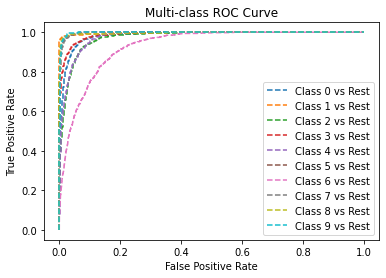

auc_score 0.9836983


In [25]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label = i)

# plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle ="--", label = f"Class {i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print("auc_score", roc_auc_score(test_labels_list,test_outputs_list,multi_class="ovo",average="macro"))